Source: https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/?utm_source=blog&utm_medium=introduction-information-extraction-python-spacy

Another source: https://www.analyticsvidhya.com/blog/2019/09/introduction-information-extraction-python-spacy/?utm_source=blog&utm_medium=how-to-build-knowledge-graph-text-using-spacy

In [1]:
# Import libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# 1. Data Preparation

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Summary_NLP/Knowledge-Graph/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

269                                      it was most popular in 1964 and 1965.
2431    many successful tamil films have been remade by other film industries.
812                                      the television series veronica mars  
695                             but first, you'll scream your bloody head off.
2469                  how does the world get represented by documentary films?
Name: sentence, dtype: object

In [4]:
# check the subject and object of one of these sentences
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


# 2. Entity Pair Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

- The main idea is to go through a sentence and extract the subject and the object when they are encountered. 
- However, an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
# trying function
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
# trying function
get_entities("the cat and the kittens were eating fried fish")

['cat', 'fried  fish']

In [8]:
# applying function into dataset
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:42<00:00, 102.18it/s]


In [9]:
entity_pairs[:5]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him']]

In [10]:
candidate_sentences["sentence"][:5]

0    confused and frustrated, connie decides to leave on her own.
1               later, a woman’s scream is heard in the distance.
2                        christian is then paralyzed by an elder.
3                                      the temple is set on fire.
4                               outside, the cult wails with him.
Name: sentence, dtype: object

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns. For the time being, let’s leave it as it is and move on to the relation extraction part.

# 3. Relation Extraction

Our hypothesis is that the predicate is actually the main verb in a sentence. This function work to locate predicate:

In [11]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.

In [12]:
# example
get_relation("John completed the task")

'completed'

In [13]:
# applying function into our dataset
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:39<00:00, 108.04it/s]


In [14]:
relations[:5]

['decides', 'heard in', 'paralyzed by', 'set on', 'wails with']

In [15]:
# top predicated located
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
called            22
produced          22
considered        20
made              20
had               20
be                18
been              18
used              17
scheduled         17
directed by       16
stars             16
written by        15
produced by       14
set               14
wrote             14
hired             14
received          13
introduced in     13
went              13
wanted            12
began in          11
won               11
began             11
features          10
gave              10
sold              10
gives              9
produced in        9
used in            9
includes           9
opened             9
shot in            9
known as     

# 4. Building Knowledge Graph

In [16]:
entity_pairs[:5]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him']]

In [17]:
relations[:5]

['decides', 'heard in', 'paralyzed by', 'set on', 'wails with']

In [18]:
# create dataframe for entity and predicates
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [19]:
kg_df[:5]

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


In [20]:
kg_df['edge'].value_counts()[:30]

is             370
was            297
released on     87
include         73
are             71
were            71
released        40
's              38
composed by     35
has             31
have            31
became          31
become          29
released in     27
included        26
called          22
produced        22
considered      20
made            20
had             20
be              18
been            18
used            17
scheduled       17
directed by     16
stars           16
written by      15
produced by     14
set             14
wrote           14
Name: edge, dtype: int64

In [21]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

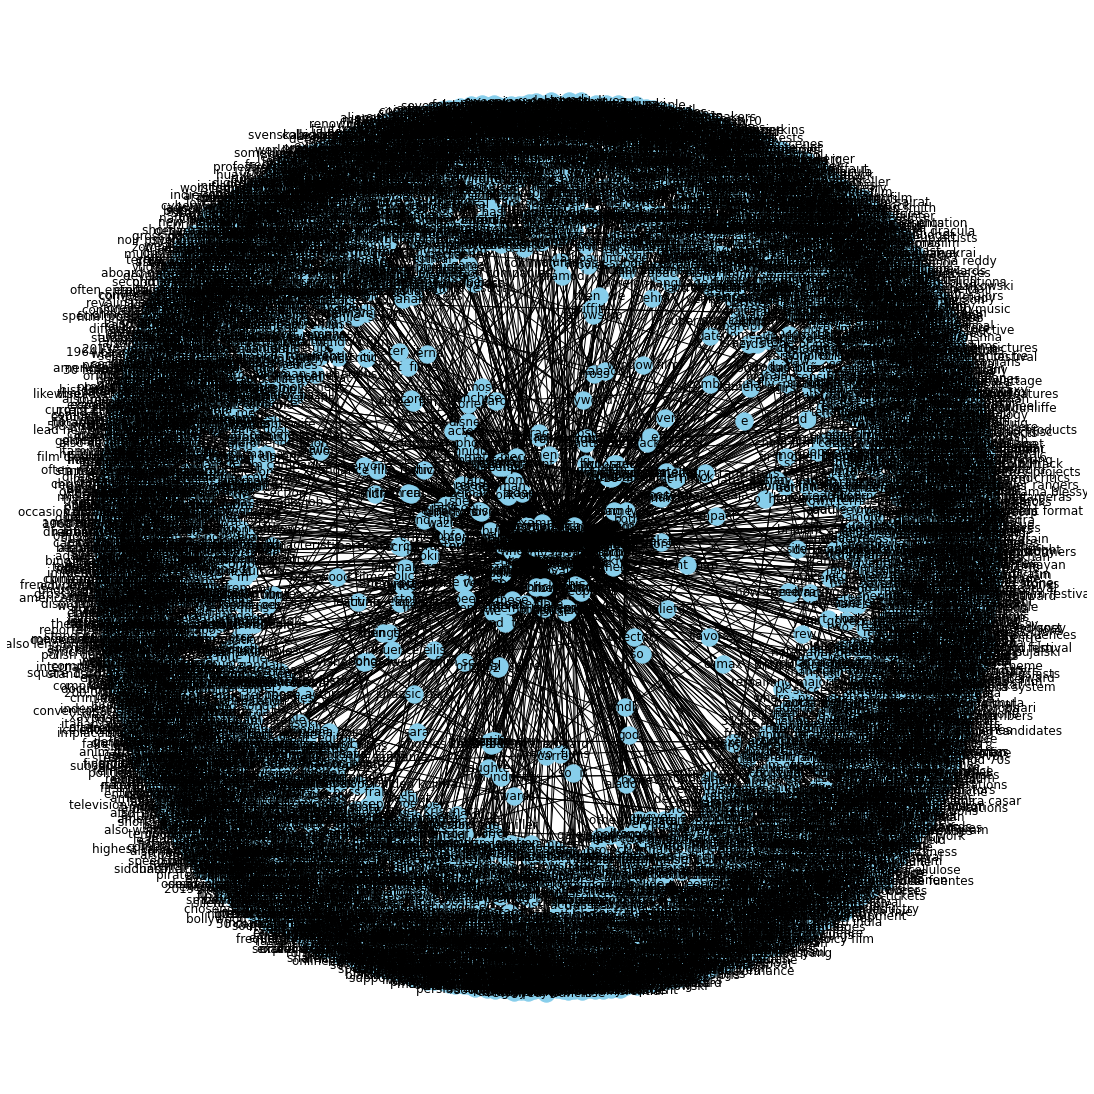

In [22]:
plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

For clearer visualization, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

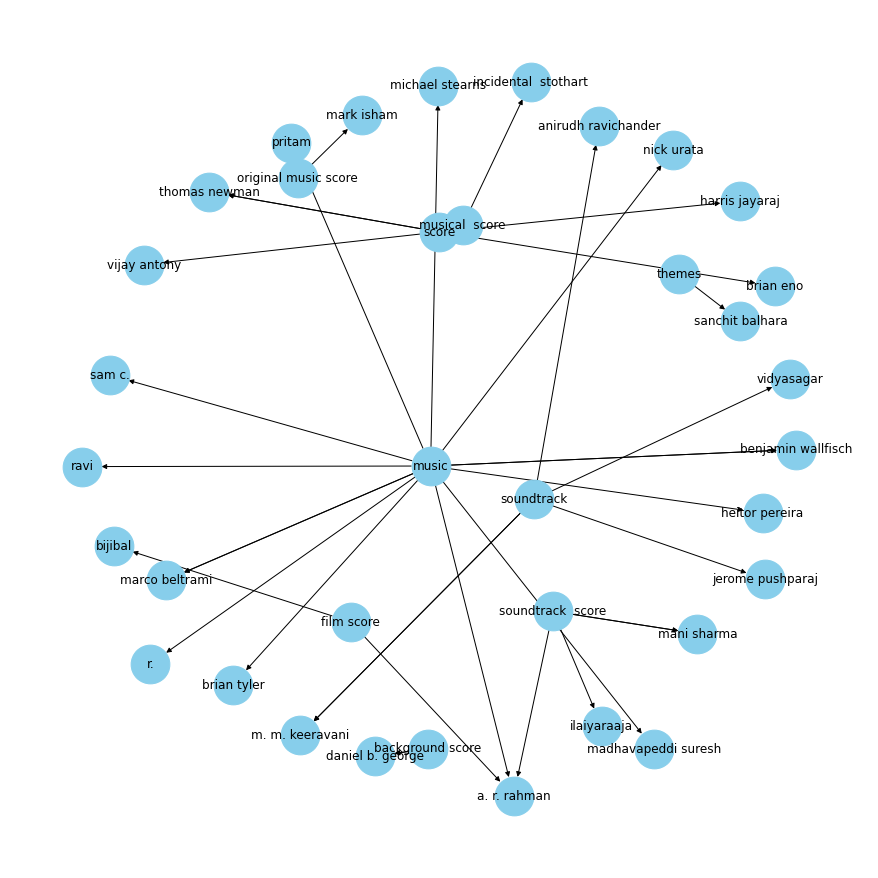

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

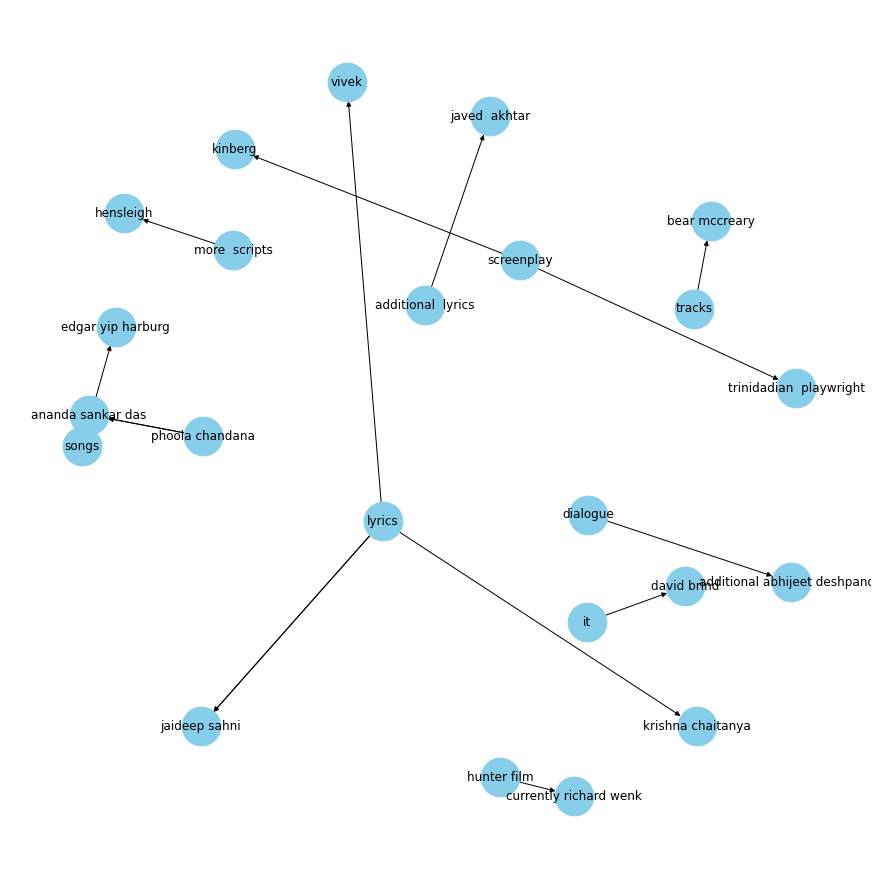

In [ ]:
# visualize the graph for the “written by” relation:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

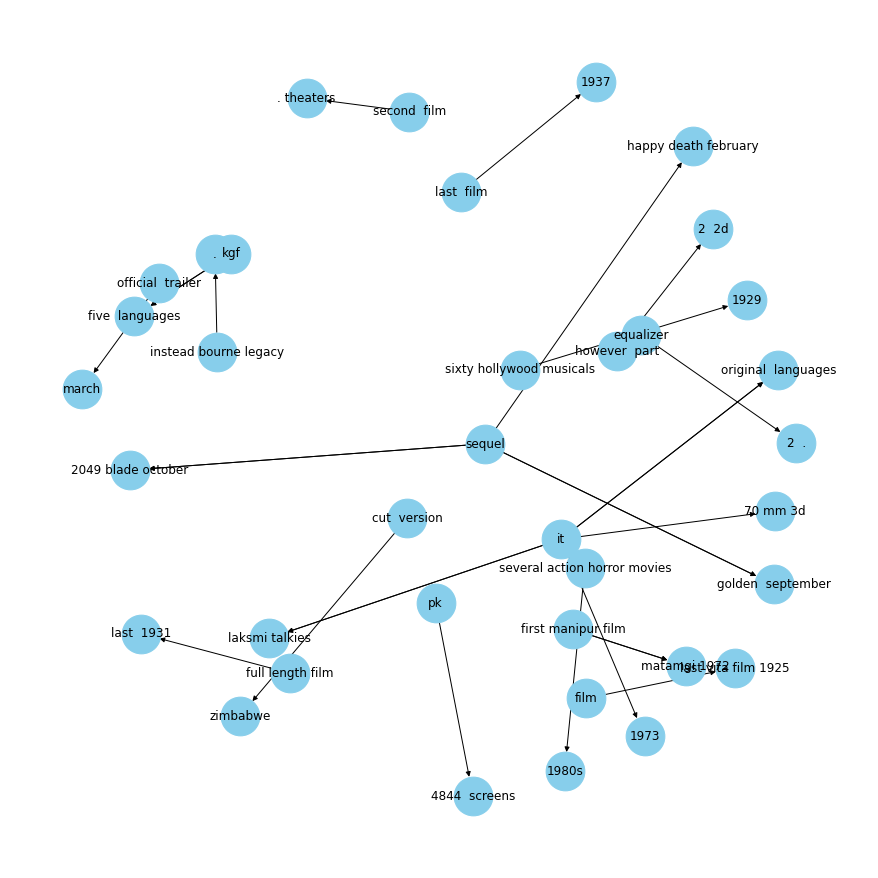

In [ ]:
# visualize "released in"
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

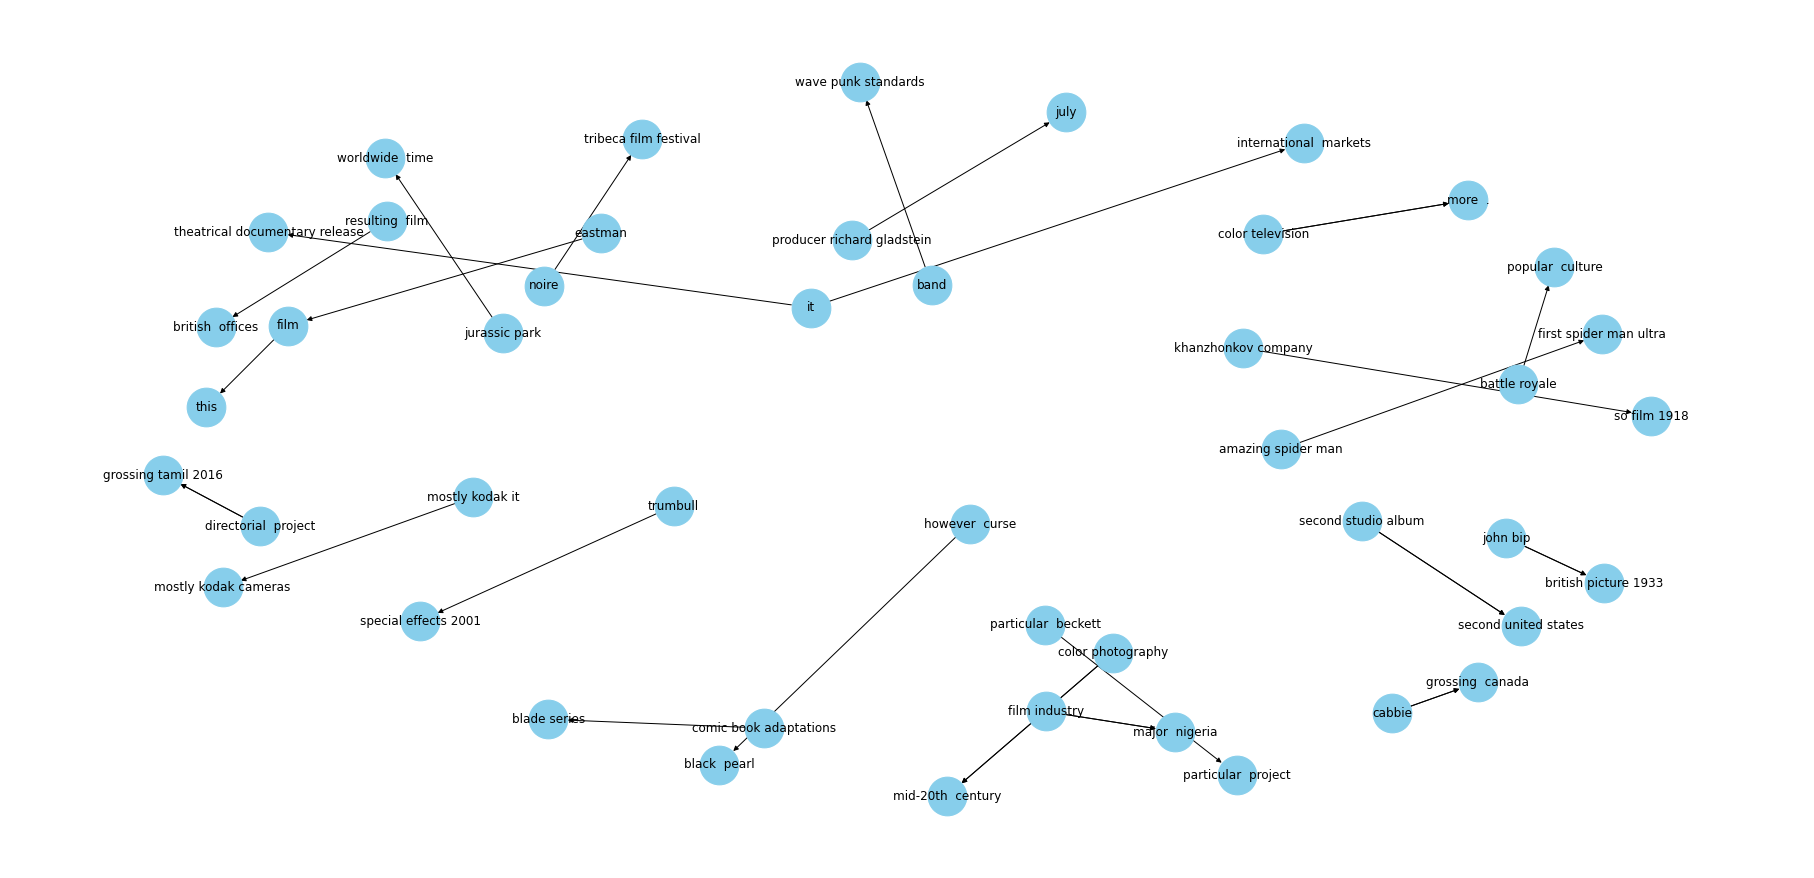

In [ ]:
# visualize "released in"
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="became"],
                          "source",
                          "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(25,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
#checking most subject term
kg_df['source'].value_counts()[:50]

it                        267
film                      222
                          147
he                        140
they                       67
i                          64
this                       55
she                        41
we                         27
films                      25
you                        21
movie                      18
music                      17
production                 16
that                       16
principal  photography     15
soundtrack                 14
album                      13
filming                    12
khan                       12
examples                   12
who                        11
series                     10
these                      10
sequel                     10
some                        7
one                         7
festival                    7
both                        7
last  release               6
plot                        6
film industry               6
score                       6
bollywood 